# Testing automatic fiducial finding

We want to automatically find fiducials and spit out an ANC file for work with peak selector

In [1]:
%matplotlib notebook
import pandas as pd
import tqdm
import numpy as np
from skimage.filters import threshold_otsu
%load_ext autoreload
%autoreload 2
import palm_utils as pu
from peaks.peakfinder import PeakFinder

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm
import glob

In [3]:
def palm_hist(df, yx_shape, subsampling=1):
    bins = [np.arange(s + subsampling, step=subsampling) - subsampling / 2 for s in yx_shape]
    # ungrouped 2d histogram to find peaks, ungrouped to make beads really stand out
    return np.histogramdd(df[["y0", "x0"]].values, bins=bins)[0]
    
def find_fiducials(df, yx_shape, subsampling=1, thresh=None):
    """Find fiducials in pointilist PALM data
    
    The key here is to realize that there should be on fiducial per frame"""
    # incase we subsample the frame number
    num_frames = df.frame.max() - df.frame.min()
    pf = PeakFinder(hist_2d, 1)
    # set the thresh to 1/10th of the number of frames (if this doesn't work drift is really bad)
#     pf.thresh = num_frames * min(subsampling, 1) * 0.12 
    # the 0.12 factor is for the DoG filter for blob finding.
    pf.blob_sigma = 1/subsampling
    # no blobs found so try again with a lower threshold
    pf.thresh = 0
    pf.find_blobs()
    blob_thresh = max(threshold_otsu(pf.blobs[:, 3]), num_frames / 10)
    if not pf.blobs.size:
        # still no blobs then raise error
        raise RuntimeError("No blobs found!")
    pf.blobs = pf.blobs[pf.blobs[:,3] > blob_thresh]
#     pf.plot_blobs(cmap="inferno", norm=PowerNorm(0.5))
    if pf.blobs[:, 3].max() < num_frames * subsampling / 2:
        print("Warning, drift maybe too high to find fiducials")
    # correct positions for subsampling
    pf.blobs[:, :2] = pf.blobs[:, :2] * subsampling
    return pf.blobs

# Refining

We can see that we pick too many fiducials above, we should drift correct and then test again

In [4]:
def remove_xy_mean(df):
    df_mean = df[["z0", "y0", "x0"]].astype(np.float).mean()
    df_new = df.copy()
    df_new[["z0", "y0", "x0"]] -= df_mean
    return df_new

def calc_drift(fiducials_df, weighted="amp", diagnostics=False):
    """"""
    if isinstance(fiducials_df, pd.DataFrame):
        return remove_xy_mean
    mean_removed = [remove_xy_mean(ff) for ff in fiducials_df]
    if diagnostics:
        fig, (ax0, ax1) = plt.subplots(1, 2)
        for ff in mean_removed:
            ff.x0.plot(ax=ax0)
            ff.y0.plot(ax=ax1)
            
    # want to do a weighted average
    # need to reset_index after concatination so that all localzations have unique ID
    df_means = pd.concat(mean_removed).reset_index()

    # Define a dictionary with the functions to apply for a given column:
    if weighted:
        wm = lambda group: np.average(group, weights=df_means.loc[group.index, weighted])
    else:
        wm = "mean"
    return df_means.groupby("frame").agg({"x0" : wm, "y0" : wm, "z0" : wm})

def remove_drift(df_data, drift):
    # make our index frame number so that when we subtract drift it aligns automatically along
    # the index, this needs to be tested.
    # this also, conveniently, makes a copy of the data
    df_data_dc = df_data.set_index("frame")
    # subtract drift only (assumes that drift only has these keys)
    df_data_dc[["x0", "y0", "z0"]] -= drift_mean
    # return the data frame with the index reset so that all localizations have
    # a unique id
    return df_data_dc.reset_index(), drift_mean

In [5]:
def calc_fiducial_stats(fid_df_list):
    """Calculate various stats"""
    fwhm = lambda x: x.std() * 2 * np.sqrt(2 * np.log(2))
    fid_stats = pd.DataFrame([f[["x0", "y0","z0", "amp"]].mean() for f in fid_df_list])
    fid_stats[["xdrift", "ydrift", "zdrift"]] = pd.DataFrame([f.agg({"x0":fwhm,"y0":fwhm, "z0":fwhm}) for
                                                    f in fid_df_list])[["x0","y0", "z0"]]
    fid_stats["sigma"] = np.sqrt(fid_stats.ydrift**2 + fid_stats.xdrift**2)
    all_drift = pd.concat([f[["x0","y0", "z0"]] - f[["x0","y0", "z0"]].mean() for f in fid_df_list])
    return fid_stats, all_drift

def extract_fiducials(df, blobs, radius, min_num_frames=0):
    """Do the actual filtering
    
    We're doing it sequentially because we may run out of memory.
    If initial DataFrame is 18 GB (1 GB per column) and we have 200 """
    fiducials_dfs = [df[np.sqrt((df.x0 - x) ** 2 + (df.y0 - y) ** 2) < radius]
        for y, x in tqdm.tqdm_notebook(blobs, leave=False, desc="Extracting Fiducials")]
    # remove any duplicates in a given frame by only keeping the localization with the largest count
    clean_fiducials = [sub_df.sort_values('amp', ascending=False).groupby('frame').first()
                       for sub_df in fiducials_dfs if len(sub_df) > min_num_frames]
    return clean_fiducials

In [6]:
def plot_stats(fids_df):
    fid, drift = calc_fiducial_stats(fids_df)
    drift[["x0","y0"]] *= 130
    fid[["x0", "xdrift", "y0", "ydrift", "sigma"]] *= 130
    fid.sort_values("sigma").reset_index().plot(subplots=True)
    fid.hist(bins=32)
    drift.hist(bins=64, normed=True, layout=(3,1), figsize=(3, 9))
#     pd.plotting.table(plt.gca(), np.round(drift.describe(), 2), loc='upper right', colWidths=[0.2, 0.2, 0.2])
    print(drift.std() * 2 * np.sqrt(2 * np.log(2)))

In [7]:
data_dict = {path:pd.read_hdf(path) for path in glob.iglob("*.h5")}

In [8]:
hists = {k:palm_hist(v, (512, 512)) for k, v in data_dict.items()}

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


<IPython.core.display.Javascript object>


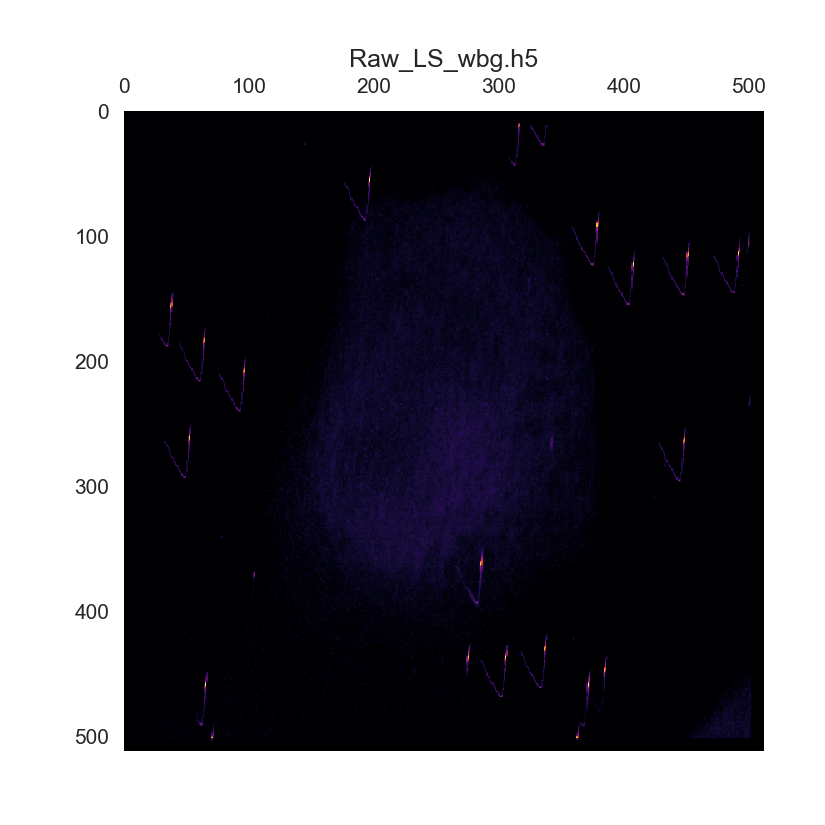

<IPython.core.display.Javascript object>


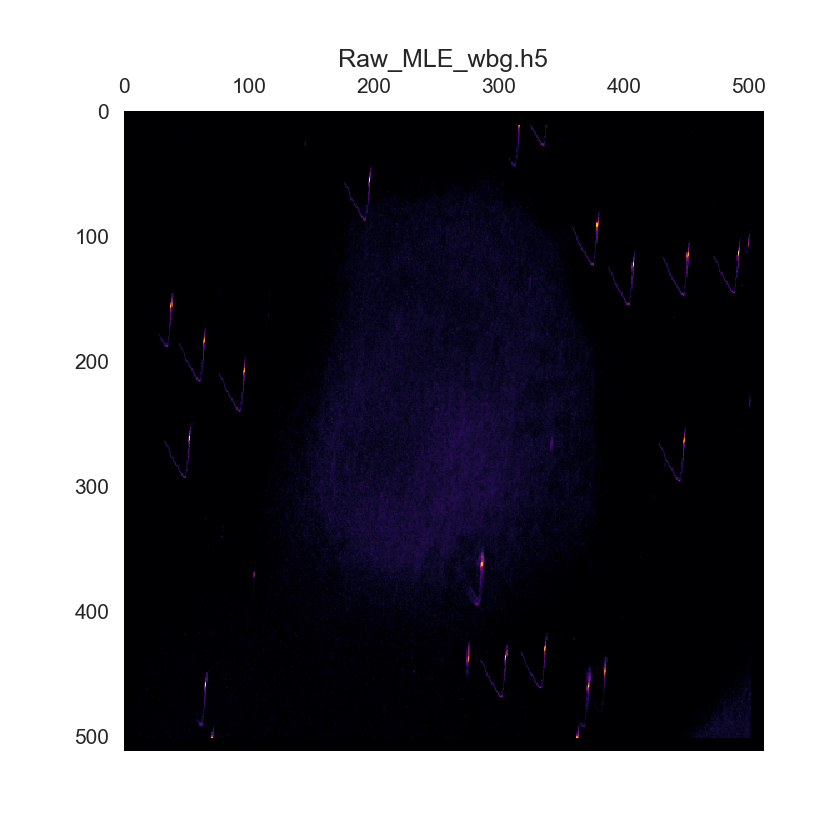

In [9]:
for k,v in hists.items():
    plt.matshow(v, cmap="inferno", norm=PowerNorm(0.5))
    plt.grid("off")
    plt.title(k)

In [10]:
pf = PeakFinder(v, 20, 200)

<IPython.core.display.Javascript object>


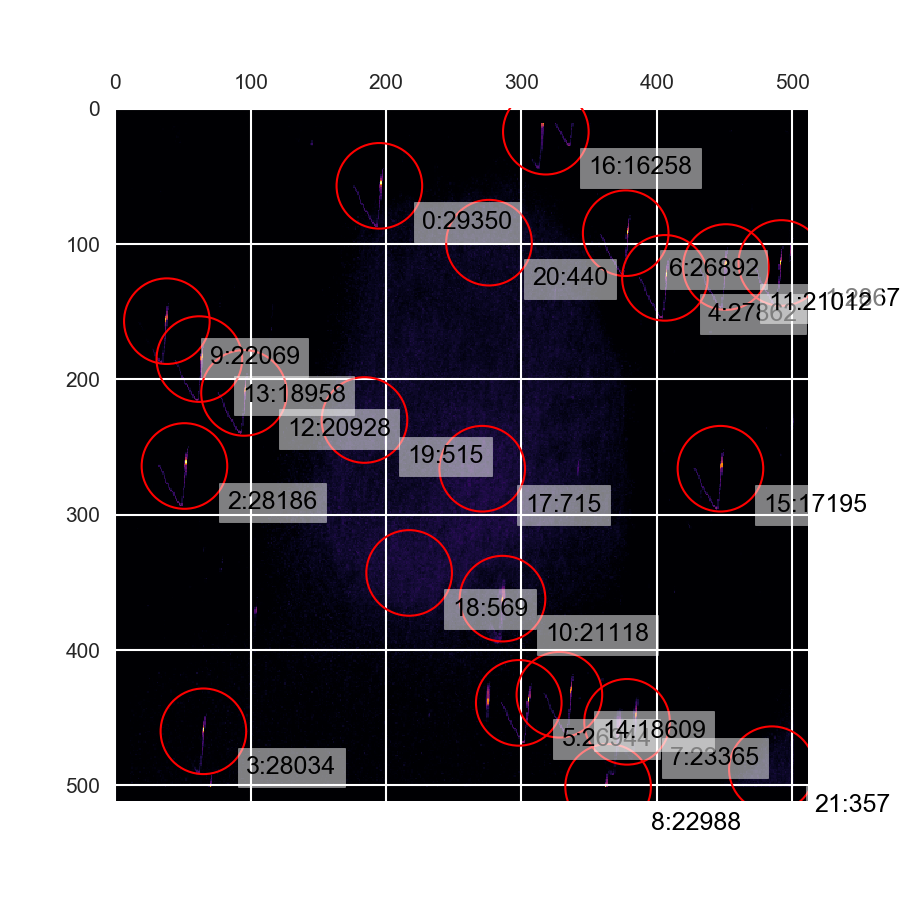

(<matplotlib.figure.Figure at 0x1bf751095f8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1bf679a0278>)

In [11]:
pf.find_blobs()
pf.plot_blobs(cmap="inferno", norm=PowerNorm(0.5))

In [12]:
initial_drift = extract_fiducials(data_dict[k], pf.blobs[15:16, :2], 40)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [ ]:
calc_drift